# Wstęp

Celem projektu jest wytrenowanie wariantów modeli: klasycznej sieci splotowej (CNN) oraz sieci resztkowej (ResNet), a następne ich porównanie. Porównanie będzie się opierać na treningu na bazie zbioru danych EMNIST. 

# Przygotowanie

## Import bibliotek

In [162]:
import pandas as pd
import numpy as np
import math
import string
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

from tqdm import tqdm
import os
from pathlib import Path
import zipfile
import random

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from models import *

## Import danych

Wykorzystamy zbiór EMNIST balanced (131600 znaków, 47 unikalnych klas) przekonwertowany i podzielony już na pliki formatu .csv </br>
Poniższy kod pobiera dane treningowe, testowe i mapujące z kaggle (https://www.kaggle.com/datasets/crawford/emnist).

In [2]:
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

os.system(f"kaggle datasets download -d crawford/emnist -p ./data")

with zipfile.ZipFile("./data/emnist.zip", 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if "balanced" in file_name and (file_name.endswith(".csv") or file_name.endswith(".txt")):
            zip_ref.extract(file_name, "./data")
            print(f"Extracted: {file_name}")
print("Dataset extracted.")


Extracted: emnist-balanced-mapping.txt
Extracted: emnist-balanced-test.csv
Extracted: emnist-balanced-train.csv
Dataset extracted.


Baza EMNIST balanced, pobrana w plikach, jest już podzielona: 112800 elementów w danych treningowych (86%) oraz 18800 w testowych (14%). Choć standardowy, zalecany (zasada Pareta) podział to 80:20, w tym przypadku liczba 18800 elementów testowych jest wystarczająca, biorąc pod uwagę rozmiar zbioru.

In [3]:
train = pd.read_csv('data/emnist-balanced-train.csv', header=None)
test = pd.read_csv('data/emnist-balanced-test.csv', header=None)

train.shape, test.shape

((112800, 785), (18800, 785))

In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112800 entries, 0 to 112799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 675.6 MB


# Analiza zbioru danych

Nie ma brakujących wartości w obu zbiorach.

In [6]:
nan_values = train.isna().sum().sum() + test.isna().sum().sum()
print(f"Liczba brakujących wartości: {nan_values}")

Liczba brakujących wartości: 0


Plik z danymi treningowymi zawiera 112800 wierszy i 785 kolumn. Pierwsza kolumna to etykieta (numer od 0 do 46), a pozostałe 784 kolumny przedstawiają piksele obrazu 28x28. Taki sam układ występuje w pliku z danymi testowymi. Etykiety odpowiadają cyfrom oraz dużym i małym literom alfabetu angielskiego. Mapowanie etykiet znajduje się w pliku emnist-balanced-mapping.txt.

In [7]:
mapping = pd.read_csv('data/emnist-balanced-mapping.txt', delimiter=' ', header=None)
mapping_dict = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

print(f"Mapping size: {len(mapping)}")
print(dict(list(mapping_dict.items())))

Mapping size: 47
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


Pełny zbiór EMNIST zawiera 62 klasy (26 małych i dużych liter alfabetu łacińskiego oraz 10 cyfr). My jednak wykorzystujemy wariant "zbalansowany" – zrównoważony zbiór wariantu scalonego ([szerszy opis](https://arxiv.org/pdf/1702.05373v1)), który ze względu na podobieństwo niektórych liter w dużej i małej formie (np. C i c) scala 15 liter: C, I, J, K, L, M, O, P, S, U, V, W, X, Y, Z, zmniejszając liczbę klas do 47 (62 - 15 = 47).

In [8]:
mapping_lowercase_letters = [val for val in mapping_dict.values() if val.isalpha() and val.islower()]
mapping_merged_letters = [val for val in mapping_dict.values() if val.isalpha() and val.isupper() and (val.lower() not in mapping_lowercase_letters)]

print(f"Liczba liter wspólnych (scalonych): {len(mapping_merged_letters)}")
print(f"Litery wspólne: {mapping_merged_letters}")

Liczba liter wspólnych (scalonych): 15
Litery wspólne: ['C', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z']


Dystrybucja etykiet (klas) w danych treningowych i testowych jest zrównoważona - każda etykieta występuje tyle samo razy. Dla danych treningowych: 47\*2400=112800, a testowych: 47\*400=18800. Gotowy podział zbioru na dane testowe i treningowe jest bardzo dobry.

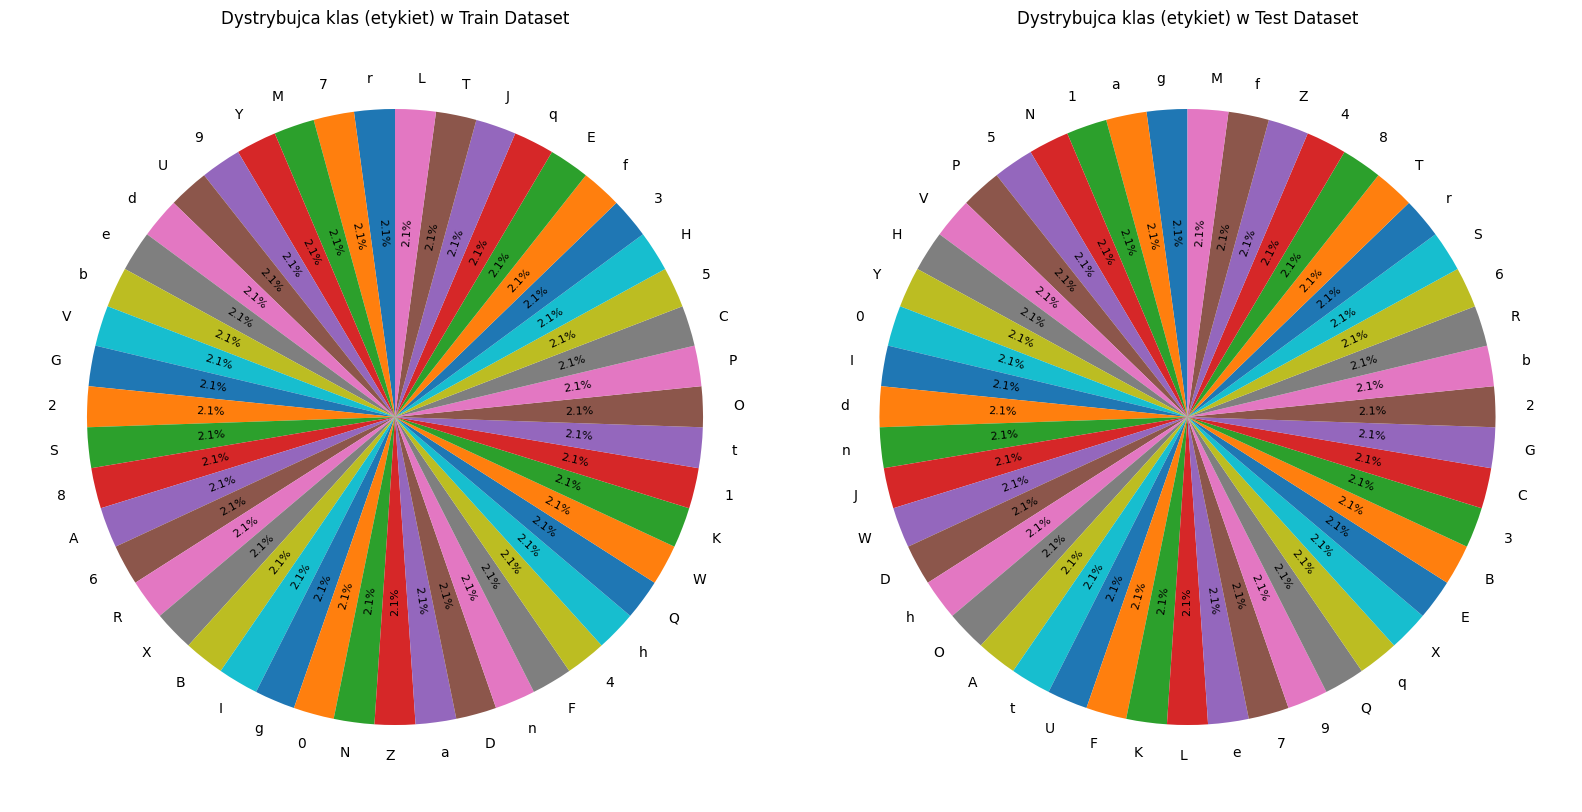

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax, (dataset_name, t_) in zip(axes, [("Train", train[0].value_counts()), ("Test", test[0].value_counts())]):
    t__classes_x = [mapping_dict.get(label, label) for label in t_.index]
    t__classes_y = t_.values

    wedges, texts, autotexts = ax.pie(
        t__classes_y,
        labels=t__classes_x,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab10.colors[:len(t__classes_x)]
    )

    for autotext in autotexts:
        autotext.set_fontsize(8)
        x, y = autotext.get_position()
        angle = math.degrees(math.atan2(y, x))
        if x <= 0:
            angle += 180
        autotext.set_rotation(angle)

    ax.set_title(f'Dystrybujca klas (etykiet) w {dataset_name} Dataset', fontsize=12)

plt.tight_layout()
plt.show()

## Poprawa danych

Teraz wyświetlimy przykładowe dane ze zbioru treningowego.

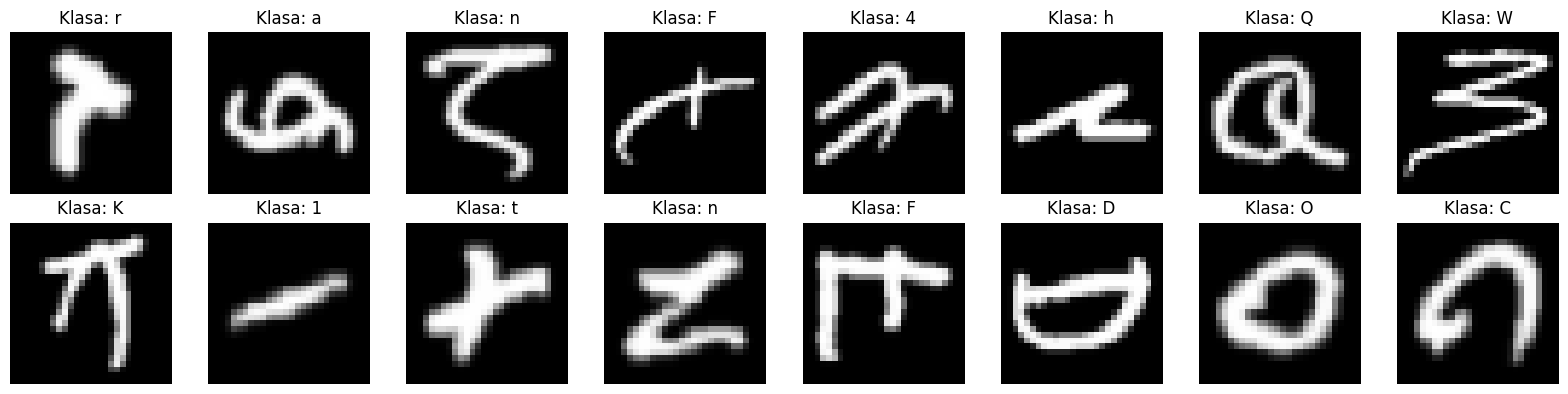

In [10]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Klasa: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Dane w zbiorze EMNIST są domyślnie odwrócone, więc należy je obrócić wokół przekątnej.

In [11]:
for t in train, test:
    for i in range(t.shape[0]):
        pixels = t.iloc[i,1:]
        image = pixels.values.reshape(28,28, 1).T
        pixels = image.flatten()
        t.iloc[i,1:] = pixels

I jeszcze raz wyświetlimy (w poprawnym już formacie) dane.

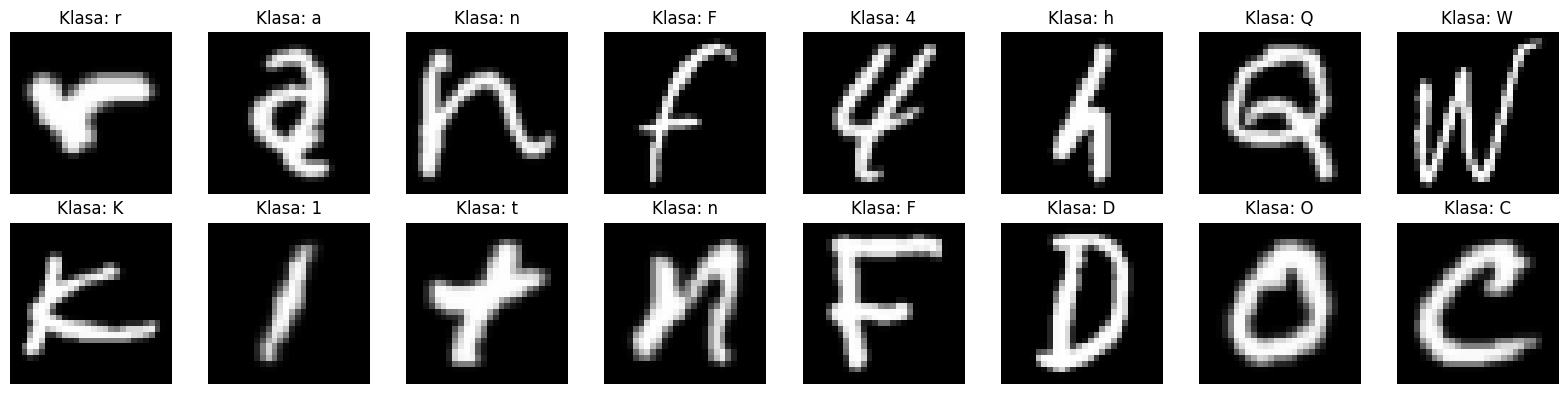

In [12]:
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i, ax in enumerate(axes.flat):
    example = train.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example, cmap='gray')
    ax.set_title(f'Klasa: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Porównywanie klas

Utworzymy teraz mapy ciepła pikseli dla każdej klasy z osobna. Każda mapa reprezentuje średni obraz danej klasy, w którym każdy piksel jest średnią arytmetyczną wartości pikseli z odpowiadających mu pozycji we wszystkich obrazach tej klasy. Nad każdym takim obrazem umieścimy liczbę reprezentującą średnią intensywność wszystkich pikseli tego przeciętnego obrazu.

C:\Users\jedno\AppData\Local\Temp\ipykernel_2600\3303963503.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.97])


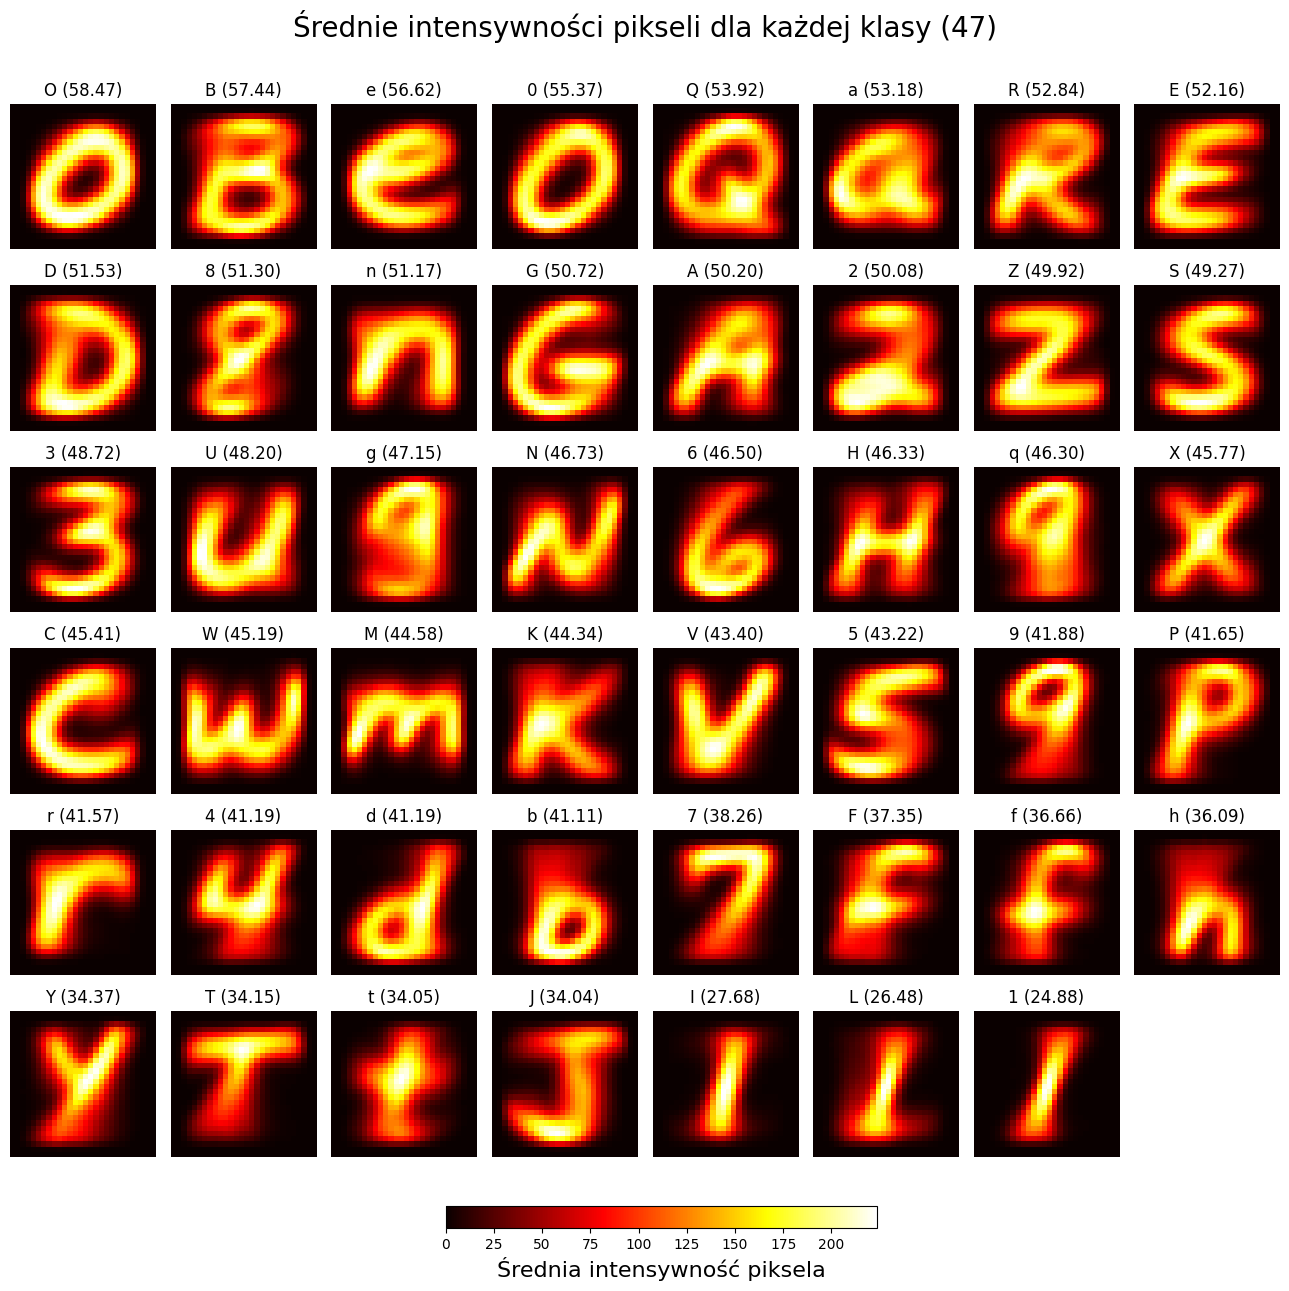

In [51]:
average_images = {}
average_images_means = {}

for label in mapping_dict.keys():
    # bierzemy wszystkie obrazy z danej klasy (label)
    images = train[train.iloc[:, 0] == label].iloc[:, 1:].values

    average_image = np.mean(images.reshape(images.shape[0], 28, 28), axis=0)
    image_mean = np.mean(average_image)
    
    # zapisujemy wyliczony przeciętny obraz oraz przeciętną wartość jego pikseli
    average_images[label] = average_image
    average_images_means[label] = image_mean

fig, axes = plt.subplots(6, 8, figsize=(13, 14))  # 6 x 8 (48, 1 pole puste)
axes = axes.flatten()

# wyświetlamy mapy ciepła posortowane wg wartości przeciętnej wartości pikseli w kolejności od najwyższej do najniższej
for idx, label in enumerate(sorted(average_images_means.keys(), key=lambda x: average_images_means[x], reverse=True)):
    average_image = average_images[label]
    image_mean = average_images_means[label]

    im = axes[idx].imshow(average_image, cmap='hot', interpolation='nearest')
    axes[idx].set_title(f"{mapping_dict[label]} ({image_mean:.2f})", fontsize=12)

# osie x, y są wyłączone dla wszystich pól, dla poprawy czytelności
for ax in axes:
    ax.axis('off')

cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Średnia intensywność piksela', fontsize=16)

plt.suptitle('Średnie intensywności pikseli dla każdej klasy (47)', fontsize=20)
plt.tight_layout(rect=[0, 0.15, 1, 0.97])
plt.show()

Teraz wyświetlimy mapę ciepła dla wszystkich obrazów. Przeciętny obraz stworzymy na podstawie przeciętnych obrazów z każdej klasy.

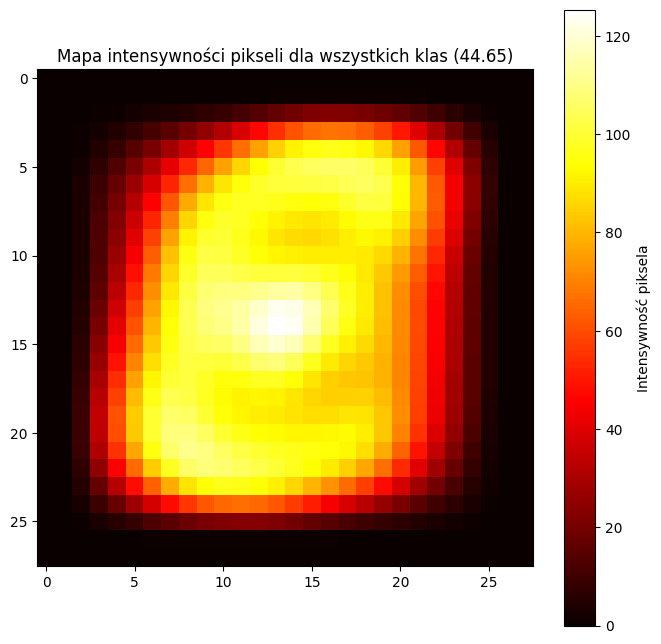

In [54]:
average_image = np.mean(list(average_images.values()), axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(average_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Intensywność piksela')
plt.title(f'Mapa intensywności pikseli dla wszystkich klas ({np.mean(average_image):.2f})')
plt.show()

Można porównać liczbę średnią liczbę zapalonych pikseli dla zdjęć z każdej klasy w bardziej widocznej formie - bar plotu. Dodamy tu również rekord ALL z naszego uśrednionego zdjęcia (wyżej). Jak widać na poniższym wykresie, jego średnia wartość zapalonego piksela plasuje się po środku plot baru.<br/><br/>Może być on punktem odniesienia do analizy, które klasy wymagają średnio więcej rozświetlonych pikseli, a które mniej.

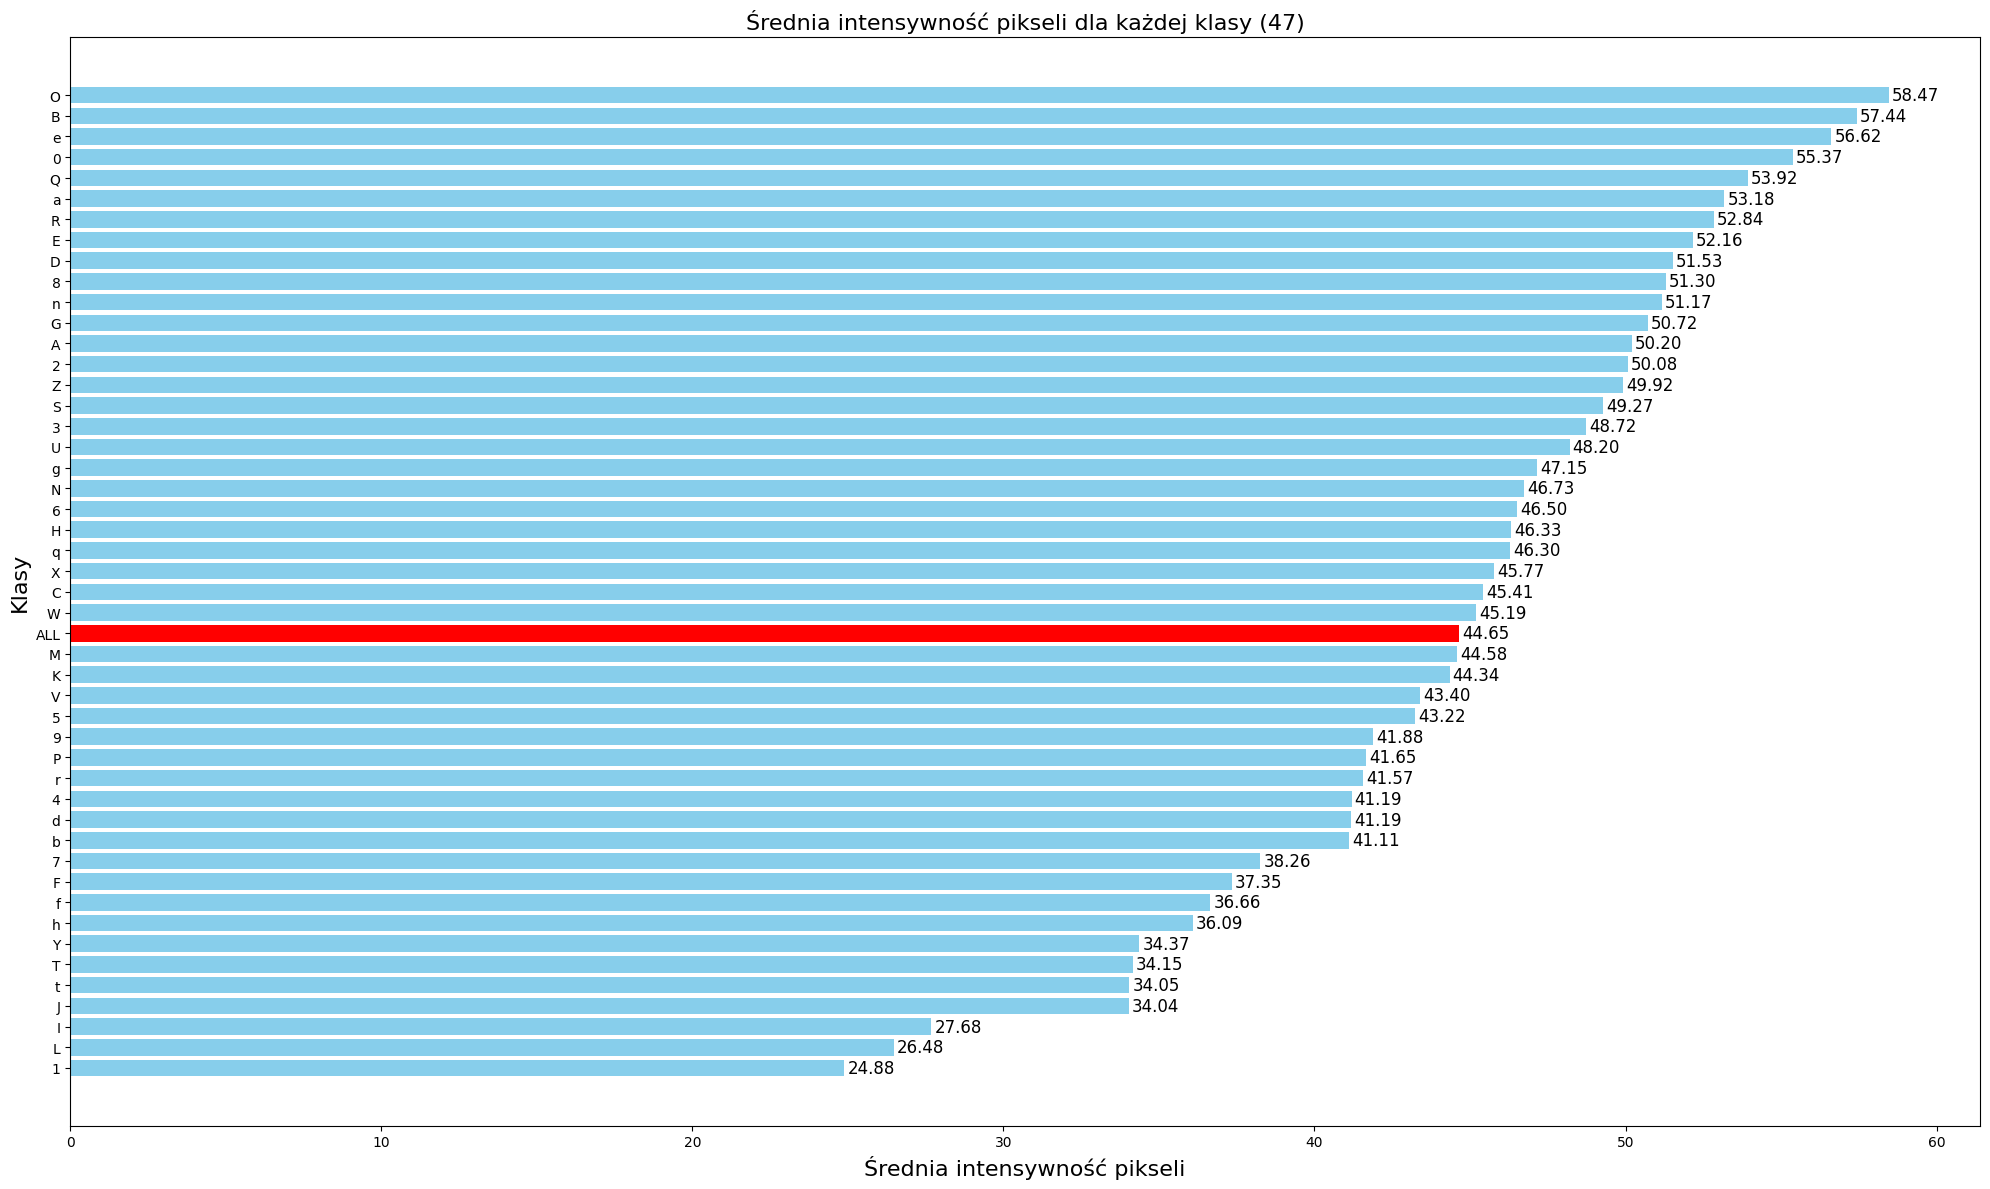

In [63]:
avg_pixels_light = {}

for idx, label in enumerate(mapping_dict.keys()):
    avg_pixels_light[mapping_dict[label]] = np.mean(average_images[label])

avg_pixels_light['ALL'] = np.mean(average_image)
avg_pixels_light = dict(sorted(avg_pixels_light.items(), key=lambda item: item[1]))

plt.figure(figsize=(20, 12))
bars = plt.barh(list(avg_pixels_light.keys()), list(avg_pixels_light.values()), color=['red' if key == 'ALL' else 'skyblue' for key in avg_pixels_light.keys()])

for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2f}", va='center', fontsize=12)


plt.xlabel('Średnia intensywność pikseli', fontsize=16)
plt.ylabel('Klasy', fontsize=16)
plt.title('Średnia intensywność pikseli dla każdej klasy (47)', fontsize=16)

plt.tight_layout()
plt.show()


## Podobieństwo klas

Na pierwszej mapie ciepła zauważyliśmy, że część klas jest bardzo podobna do siebie - np. 1, I, L. Człowiek może mieć kłopot z rozdzieleniem tych znaków, co może już świadczyć o problemach w uczeniu.<br/><br/>
Podzielimy teraz klasy na grupy. Do podziału użyjemy metody k-średnich (KMeans), która wyznacza współrzędne k-punktów, będące środkami k-klastrów. Najbardziej optymalną liczbę grup (klastrów) znajdziemy za pomocą porównania współczynników silhouette (sylwetki) dla różnych liczb grup. Współczynnik określa średnie podobieństwo obiektu do innych obiektów w danym klastrze. Im współczynnik bliższy jest 1, tym lepiej obiekt/obiekty dopasowane są do klastra.


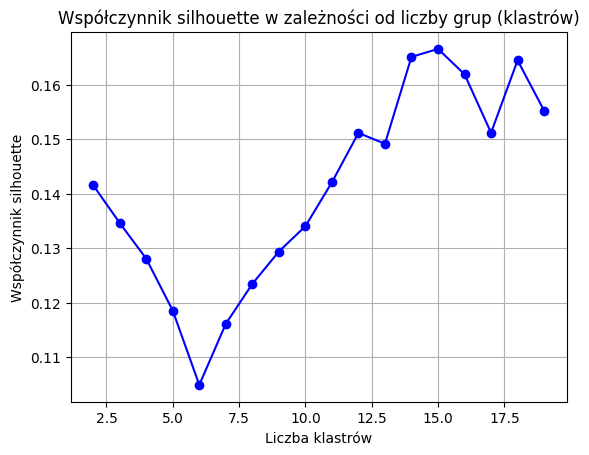

Optymalna liczba klastrów: 15
Grupa 4: ['0', 'D', 'O']
Grupa 3: ['1', 'I', 'L', 't']
Grupa 12: ['2', 'Z']
Grupa 13: ['3', 'B', 'S']
Grupa 1: ['4', 'A', 'H', 'N', 'R', 'd']
Grupa 2: ['5', 'E', 'J', 'T']
Grupa 11: ['6', 'b']
Grupa 5: ['7', '9', 'g', 'q']
Grupa 6: ['8', 'F', 'P', 'f']
Grupa 10: ['C', 'e']
Grupa 7: ['G', 'Q']
Grupa 9: ['K', 'X', 'Y', 'h']
Grupa 8: ['M', 'W']
Grupa 15: ['U', 'V', 'a']
Grupa 14: ['n', 'r']


In [117]:
def optimal_clusters_count(X):
    scores = []

    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)

    plt.plot(range(2, 20), scores, 'bo-', label='Współczynnik sylwetki')

    plt.title('Współczynnik silhouette w zależności od liczby grup (klastrów)')
    plt.xlabel('Liczba klastrów')
    plt.ylabel('Współczynnik silhouette')

    plt.grid(True)
    plt.show()

    return np.argmax(scores) + 2

average_images_flatten = np.array([image.flatten() for image in average_images.values()])

optimal_n = optimal_clusters_count(average_images_flatten)
print(f"Optymalna liczba klastrów: {optimal_n}")

kmeans = KMeans(n_clusters=optimal_n, random_state=42)
labels = kmeans.fit_predict(average_images_flatten)

grouped_images = {}
for i, label in enumerate(labels):
    image_label = list(average_images.keys())[i]
    if label not in grouped_images:
        grouped_images[label] = []
    grouped_images[label].append(image_label)

for group, images in grouped_images.items():
    print(f"Grupa {group + 1}: {[mapping_dict[im] for im in images]}")


Najlepszy wynik wpółczynnika sylwetki (wykres powyżej) nie przekracza 0.2 (uważa się wynik bliski 1 oznacza dobrą separację obiektów, a 0.25 już za słabą), zatem na wykresie grupowym nie będzie widać dobrego rozróżnienia między poszczególnymi grupami.<br/><br/>
Do wyświetlenia podziału naszych grup użyjemy metody analizy głównych składowych PCA. Zredukujemy nasze dane do 2 wymiarów - osi X i Y.

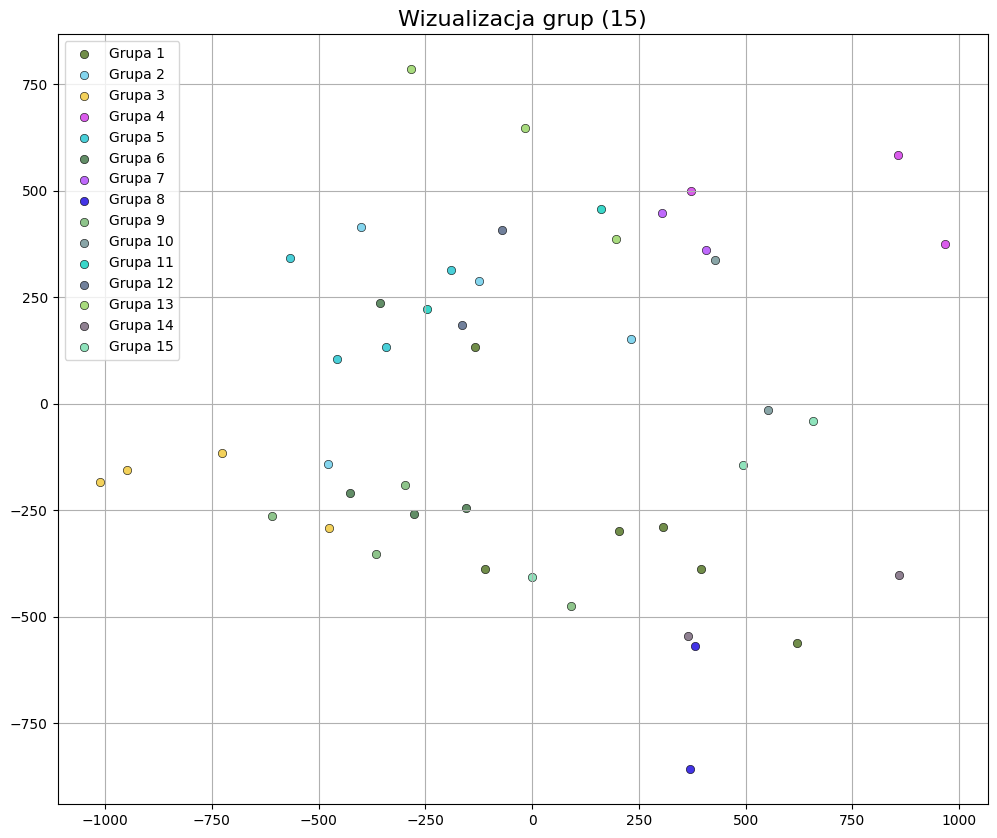

In [140]:
images_2d = PCA(n_components=2).fit_transform(average_images_flatten)

group_distances = {}
for l in range(optimal_n):
    group_indices = np.where(labels == l)[0]
    group_points = average_images_flatten[group_indices]

    # średnia odległość elementów w danym klastrze
    intra_distances = pairwise_distances(group_points).mean()
    group_distances[l] = intra_distances

# losowe kolory dla grup
colors = [tuple(np.random.rand(3)) for _ in range(optimal_n)]

plt.figure(figsize=(12, 10))
for label in range(optimal_n):
    cluster_points = images_2d[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f'Grupa {label + 1}', 
                color=colors[label], alpha=0.8, edgecolors='black', linewidth=0.5)

plt.title(f'Wizualizacja grup ({optimal_n})', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


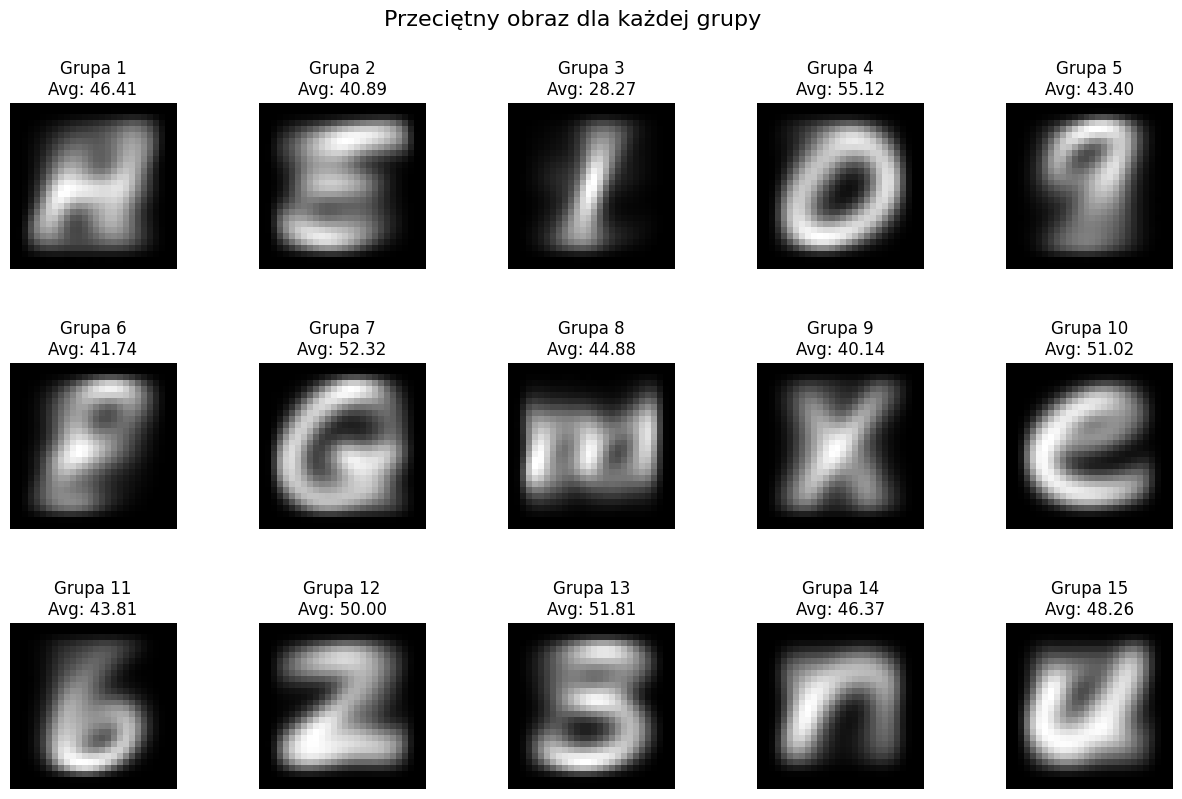

In [156]:
group_avg_images = {}
for label in range(optimal_n):
    # zbieramy etykiety obrazów w danej grupie
    group_indices = np.where(labels == label)[0]
    # i ich obrazy
    group_images = [average_images_flatten[i] for i in group_indices]
    # wyznaczamy przeciętny obraz
    mean_image = np.mean(group_images, axis=0)
    group_avg_images[label] = mean_image.reshape(average_images[next(iter(average_images))].shape)

num_cols = 5
num_rows = (optimal_n + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
axes = axes.flatten()

for i, (label, avg_image) in enumerate(group_avg_images.items()):
    ax = axes[i]
    ax.imshow(avg_image, cmap='gray')
    ax.set_title(f'Grupa {label + 1}\nAvg: {np.mean(avg_image):.2f}')

for ax in axes:
    ax.axis('off')

plt.suptitle('Przeciętny obraz dla każdej grupy', fontsize=16)
plt.show()


Wyświetlimy teraz 3 obrazy (lub mniej, w zależności od liczby elementów w grupie) z każdej grupy. Tutaj można zauważyć bardzo duże podobieństwo obrazów w niektórych grupach: 3 (1, I, L), 4 (O, D, 0), 5 (9, G), 10 (C, e), 11 (6, b).

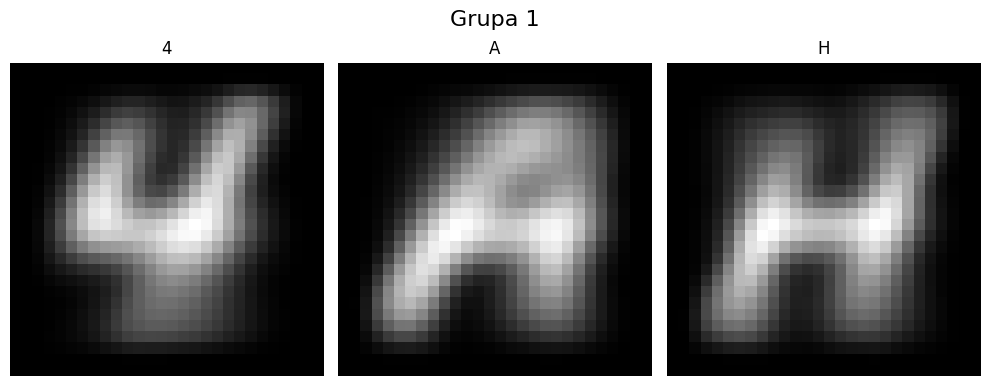

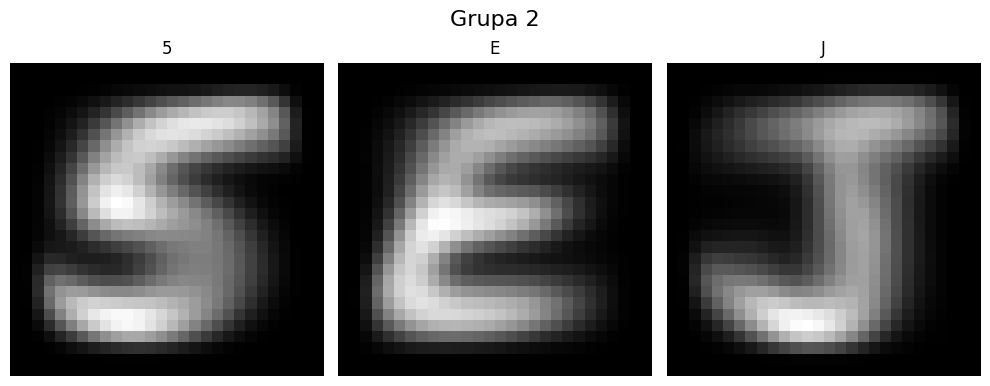

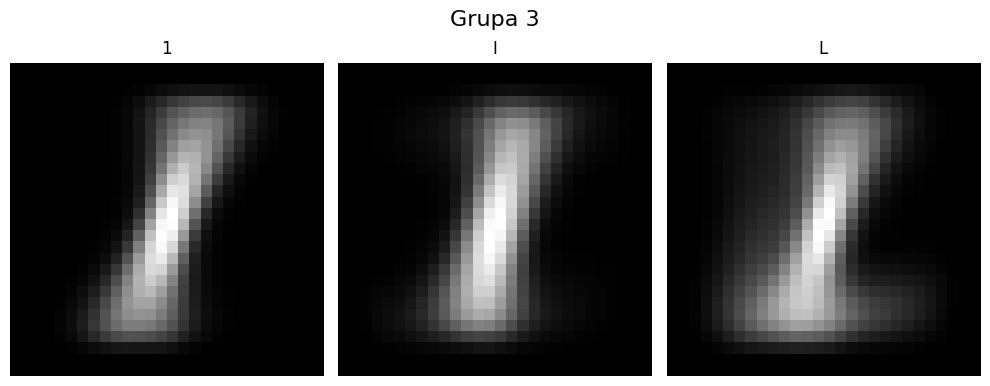

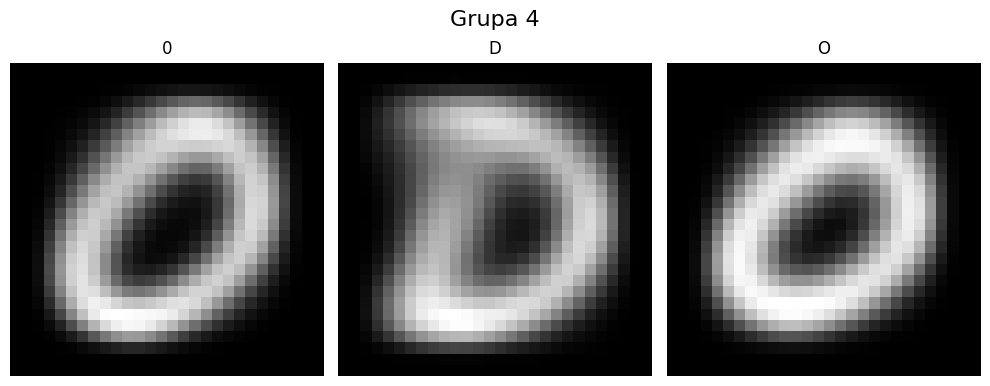

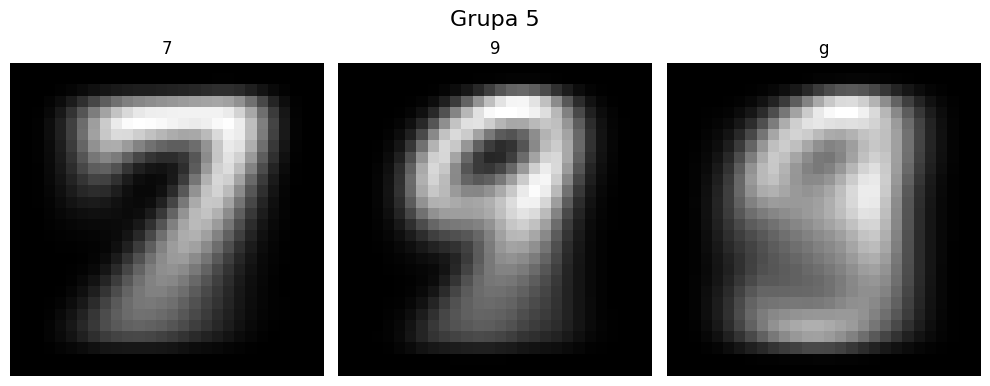

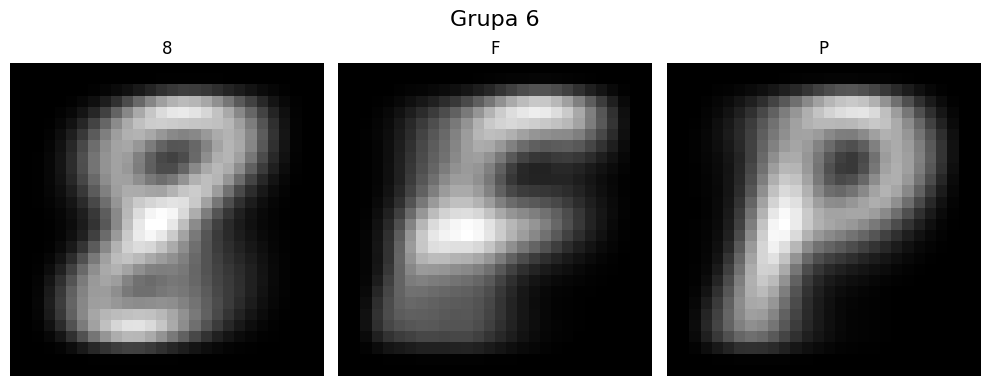

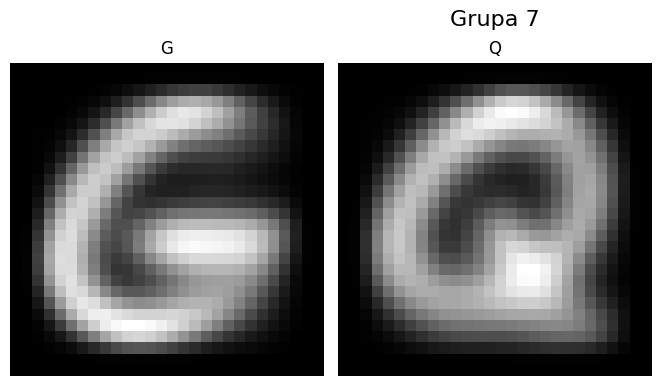

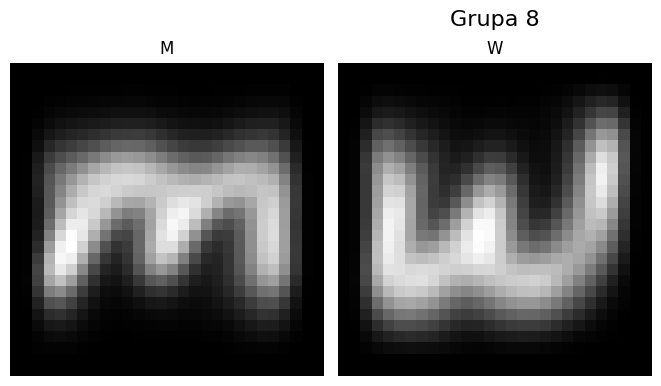

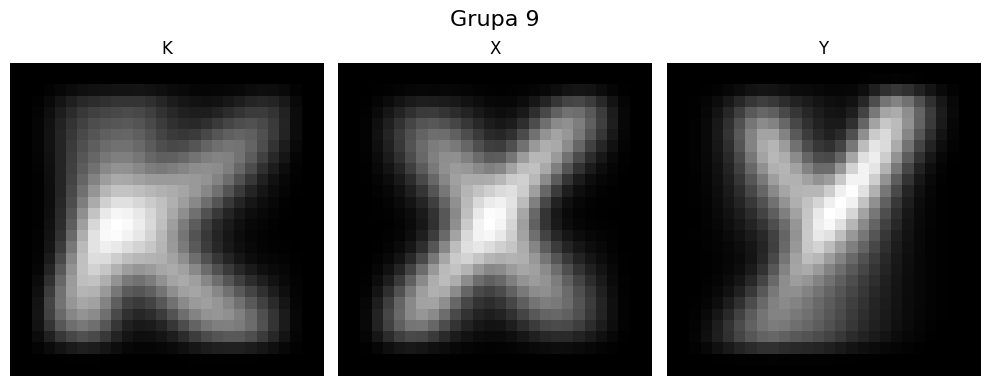

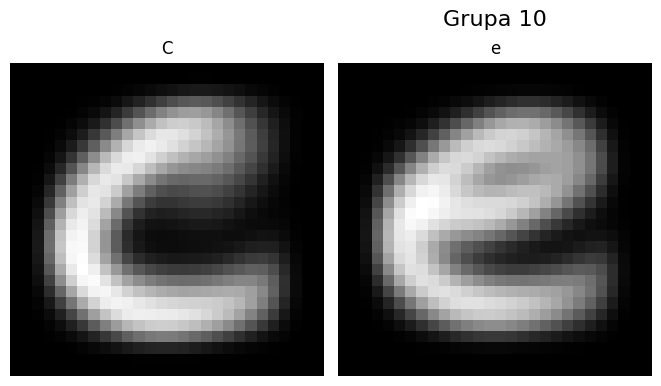

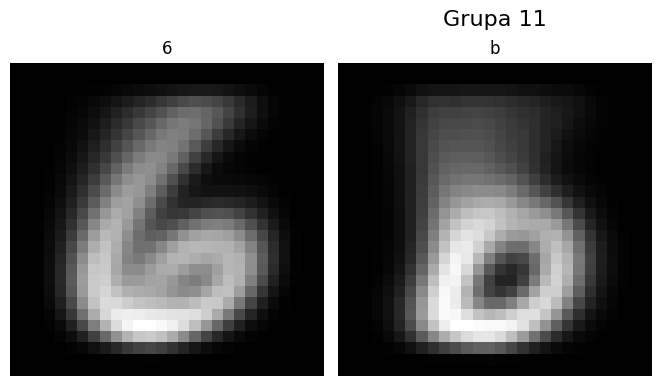

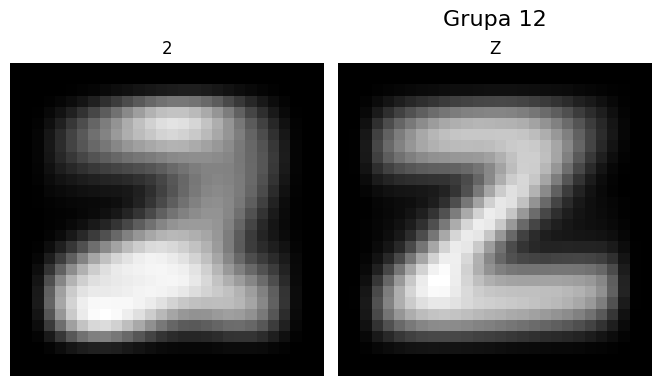

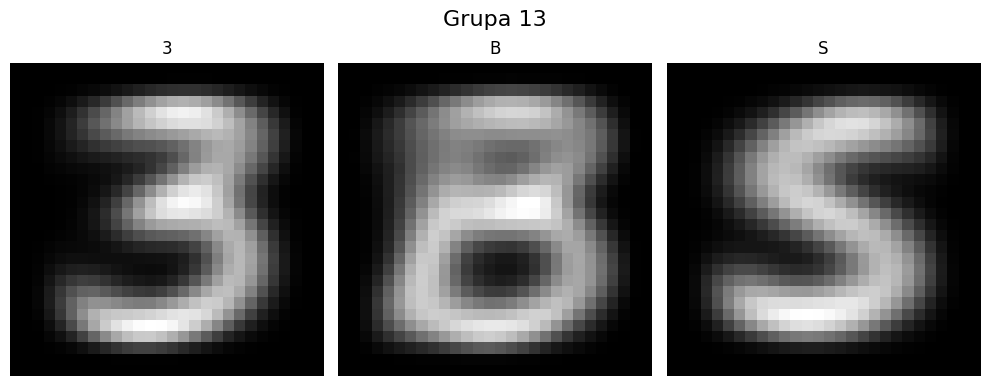

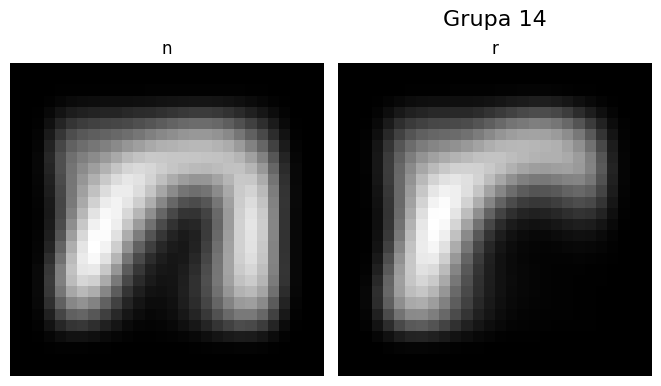

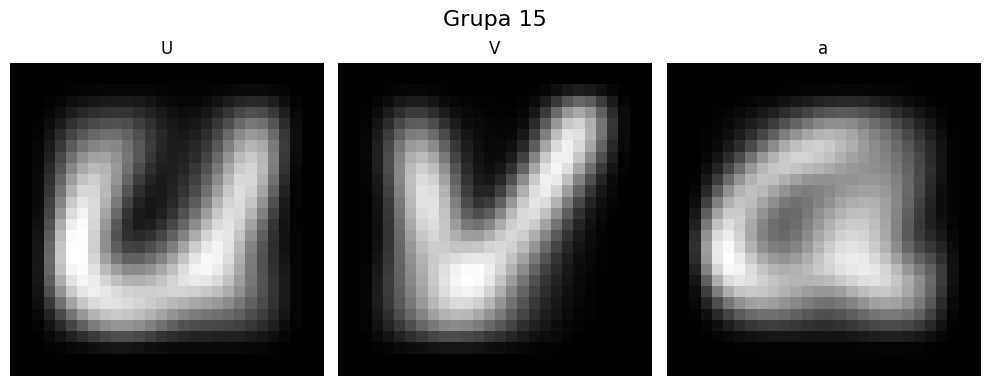

In [161]:
images_per_group = {}

n_images = 3

for label in range(optimal_n):
    group_labels = np.where(labels == label)[0]
    group_images = [average_images_flatten[i] for i in group_labels]
    images_per_group[label] = (group_images[:n_images], group_labels[:n_images])

for label, (top_images, top_indices) in images_per_group.items():
    plt.figure(figsize=(10, 4))
    
    for i, image in enumerate(top_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(np.array(image).reshape(average_images[next(iter(average_images))].shape), cmap='gray')
        plt.axis('off')

        plt.title(f'{mapping_dict[top_indices[i]]}')
    
    plt.suptitle(f'Grupa {label + 1}', fontsize=16)
    plt.tight_layout()
    plt.show()


# Trening

Pobieramy napisane wcześniej [modele](models.py), by na nich wytrenować zbiór EMNIST.

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # vrrrrrrrrrrrrrrrrrom

In [89]:
train_X = train.iloc[:, 1:].reset_index(drop=True).values / 255.0
train_y = train.iloc[:, 0].reset_index(drop=True).values

train_dataset = EMNISTDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [90]:
test_X = test.iloc[:, 1:].reset_index(drop=True).values / 255.0
test_y = test.iloc[:, 0].reset_index(drop=True).values

test_dataset = EMNISTDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [ ]:
sampleX, sampley = next(iter(train_dataloader))

sampleX.shape, sampley.shape

image = sampleX[0].squeeze() #.permute(-2, -1)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {mapping_dict[sampley[0].item()]}')
plt.show()

In [96]:
models = {
    "simple-base": SimpleCNN().to(device),
    "simple-deep": SimpleCNNDeep().to(device),
    "simple-wide": SimpleCNNWide().to(device),
    "resnet": ResNet(ResidualBlock, layers=[1, 1, 1, 1], num_classes=47).to(device),
}

Będziemy przez każdy model przepuszczać po 10 razy dane treningowe.

In [93]:
EPOCHS = 10

Trenowanie modeli:

In [ ]:
results = {}

criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

for model_name, model in models.items():
    print(f"\nTraining {model_name}")
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_accuracies = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train - {model_name}]", leave=False)

        for inputs, labels in train_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)

        train_epoch_loss = train_loss / len(train_dataloader)
        train_epoch_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_epoch_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_progress_bar = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val - {model_name}]", leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)

        val_epoch_loss = val_loss / len(test_dataloader)
        val_epoch_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_epoch_accuracy)

        print(f"{model_name} - Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

        scheduler.step(val_epoch_loss)

        if val_epoch_accuracy >= 90:
            break

    results[model_name] = {
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    print(f"Finished Training {model_name}")

Teraz przetestujemy wyniki trenowania obu sieci na zbiorze danych testowych.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.tab10

plt.figure(figsize=(10, 7))

legend_handles = []

for idx, (model_name, metrics) in enumerate(results.items()):
    base_color = colors(idx / len(results))
    epochs = range(1, len(metrics["train_accuracies"]) + 1)

    plt.plot(epochs, metrics["train_accuracies"], color=base_color, linestyle="--", alpha=0.8)
    plt.plot(epochs, metrics["val_accuracies"], color=base_color, linestyle="-", alpha=0.8)

    legend_handles.append(plt.Line2D([0], [0], color=base_color, lw=2, label=model_name))

plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.title("Training and Validation Accuracies")
plt.xticks(range(1, EPOCHS + 1))
plt.legend(handles=legend_handles, title="Models")
plt.grid(True)
plt.show()


Na powyższym wykresie można zaobserwować zmianę poziomu dokładności modelu (*accuracy*), w zależności od numeru treningu (*epoch*). Linie ciągłe reprezentują dokładność uzyskaną na danych testowych, natomiast linie przerywane przedstawiają dokładność na danych treningowych.

<h2>Serializacja modeli</h2>

Serializujemy wyniki treningów obu modeli. Wytrenowane, można wykorzystać do dalszej analizy.

In [98]:
for model_name, model in models.items():
    torch.save(model.state_dict(), f'models/{model_name}.pth')

# Porównanie modeli

### Modele wybrane do porównania:

#### 1. Prosta sieć neuronowa złożona z:
kilku bloków, zawierających:
- warstwę konwolucyjną
- funkcję aktywacji ReLU
- normalizację wsadową
- warstwę dropout (p = 0.2)
- warstwę poolingową typu Max

na końcu:
- warstwę poolingu adaptacyjnego z biblioteki PyTorch, która dostosowuje rozmiar map cech do ustalonego rozmiaru wyjściowego
- warstwę w pełni połączoną

Ta sieć została przetestowana 3-krotnie, przyjmując różne jej warianty:
- A. Wersja bazowa (liczba warstw: 3, liczba filtrów: 64, 128, 256)
- B. Wersja "głębsza" (liczba warstw: 4, liczba filtrów: 32, 64, 128, 256)
- C. Wersja "szersza" (liczba warstw: 3, liczba filtrów: 128, 256, 512)

#### 2. Model oparty o architekturę ResNet wytrenowaną od zera (w okrojonej formie, ponieważ zbiór danych jest dość prosty)
Dla porównania: ResNet18 składa się z 4 bloków (w każdym 2 bloki residualne), a nasz model składa się z 4 bloków (w każdym 1 blok residualny).

#### Każdy z modeli trenowany był:
- przez 20 epok
- z wykorzystaniem optymalizatora Adam (momentum=0.9)
- za pomocą funkcji straty Entropii Krzyżowej
- z wykorzystaniem współczynnika uczenia równego: 1e-3
- zastosowano harmonogram współczynnika uczenia: zmniejszenie wartości x10 po 5 epokach braku poprawy straty na zbiorze walidacyjnym
- zastosowano regularyzację w postaci normy L2 (lambda=1e-4) w celu zapobiegania przeuczeniu
- rozmiar mini-paczki danych: 256

#### Poniżej przedstawiono przebiegi uczenia dla każdego z modeli

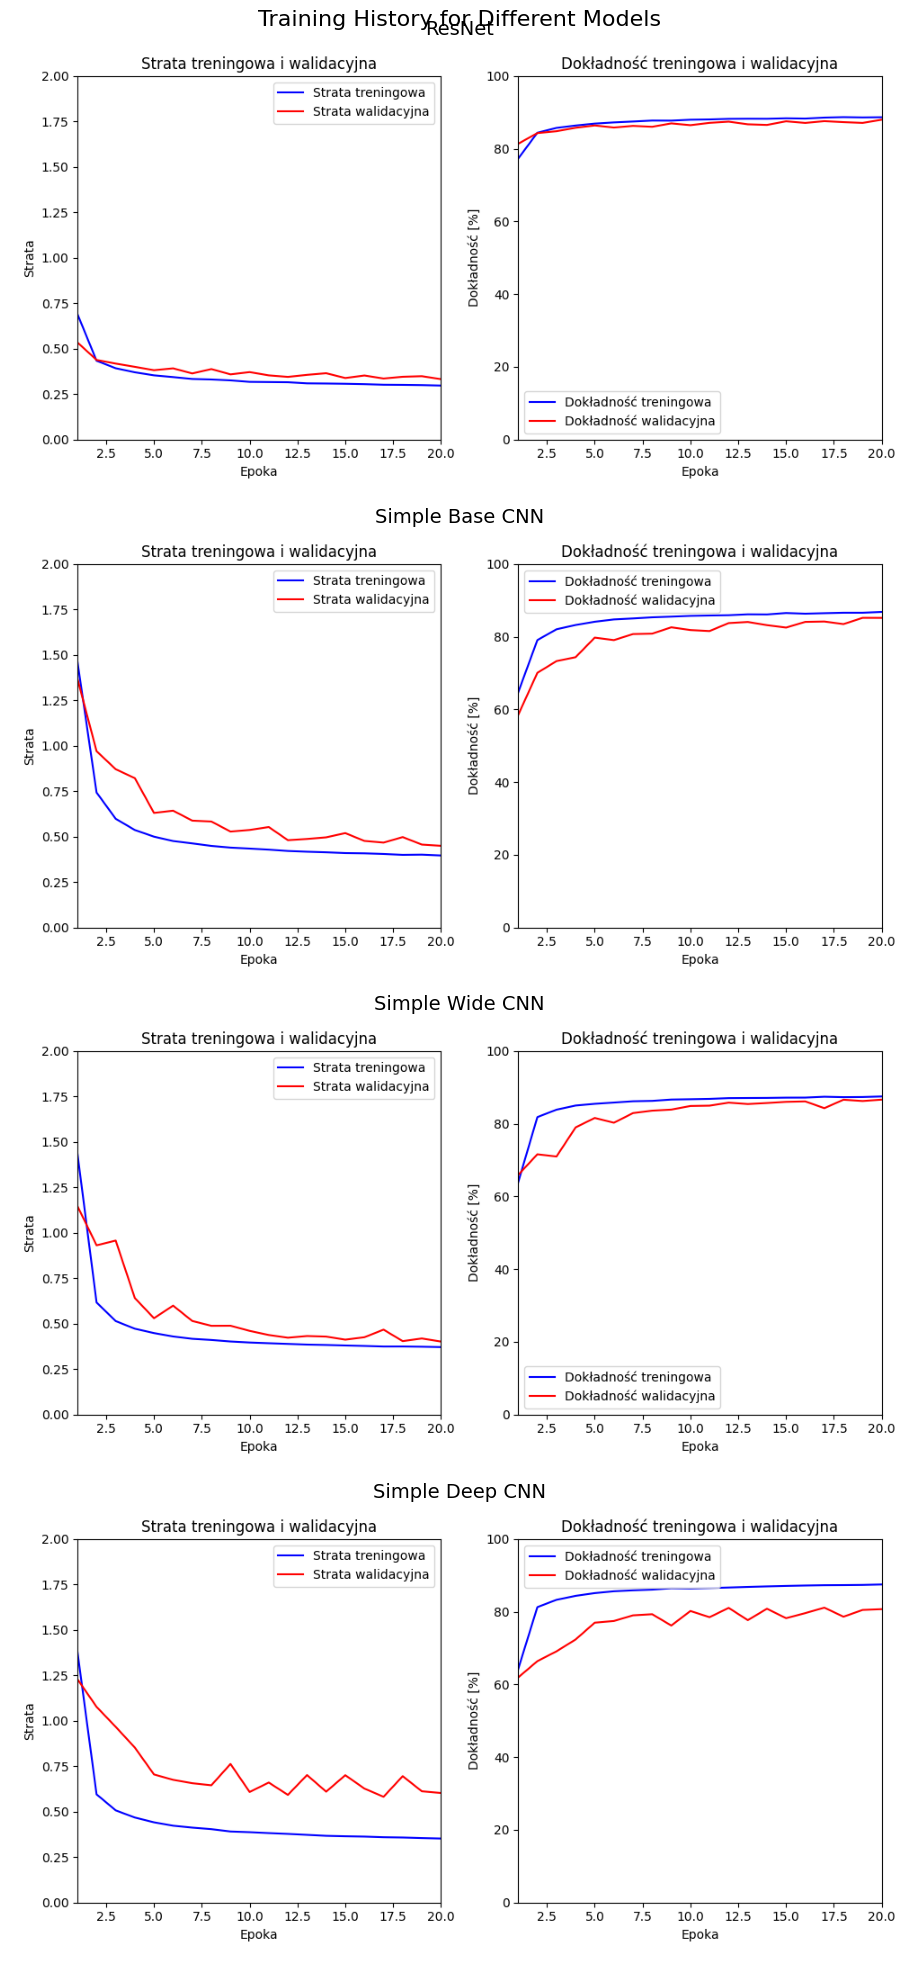

In [ ]:
# Wyświetlenie przebiegów uczenia modeli
resnet_wykres = "wykresy/training_history_resnet.png"
simple_base_wykres = "wykresy/training_history.png"
simple_wide_wykres = "wykresy/training_history_wide.png"
simple_deep_wykres = "wykresy/training_history_deep.png"

fig, axs = plt.subplots(4, 1, figsize=(20, 20))
plt.suptitle('Historia uczenia poszczególnych modeli', fontsize=16)

images = [resnet_wykres, simple_base_wykres, simple_wide_wykres, simple_deep_wykres]
titles = ['ResNet', 'Simple Base CNN', 'Simple Wide CNN', 'Simple Deep CNN']

for i, (img_path, title) in enumerate(zip(images, titles)):
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=14)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

#### Wczytanie wytrenowanych wag wszystkich modeli w celu porównania

In [ ]:
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes=47).to(device)
resnet.load_state_dict(torch.load("modele/resnet.pth"))

simple_base = SimpleCNN().to(device)
simple_base.load_state_dict(torch.load("modele/simple-base.pth"))

simple_wide = SimpleCNNWide().to(device)
simple_wide.load_state_dict(torch.load("modele/simple-wide.pth"))

simple_deep = SimpleCNNDeep().to(device)
simple_deep.load_state_dict(torch.load("modele/simple-deep.pth"))

models = [resnet, simple_base, simple_wide, simple_deep]

In [ ]:
def ocen_model(model, dataloader, class_names, true_labels):
    print(f'Model: {model.__class__.__name__}')
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    
    y_pred = np.array(all_preds)
    acc = accuracy_score(true_labels, y_pred)
    print(f'Dokładność: {acc:.4f}')
    print(f'Raport klasyfikacji:\n{classification_report(true_labels, y_pred)}')
    
    cm = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(15, 15))
    plt.title(f'Macierz pomyłek dla modelu {model.__class__.__name__}')
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names.values(), 
                yticklabels=class_names.values())
    plt.show()

#### Poniżej wczytuję dane testowe i przetwarzam je w taki sam sposób, jak dane treningowe.

In [ ]:
# wczytanie danych testowych
df_test = pd.read_csv('emnist-balanced-test.csv', header=None)

# odwrócenie obrazów, żeby były pionowo, prawidłowo
for i in range(df_test.shape[0]):
    pixels = df_test.iloc[i,1:]
    
    image = pixels.values.reshape(28,28).T
    pixels = image.flatten()
    
    df_test.iloc[i,1:] = pixels

# podział danych na dane i etykiety + normalizacja
X_test = df_test.iloc[:, 1:].values / 255.0
y_test = df_test.iloc[:, 0].values

# wczytanie mapowania klas (nazw klas)
mapping = pd.read_csv('emnist-balanced-mapping.txt', delimiter=' ', header=None)
class_names = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

# utworzenie datasetu i dataloadera
test_dataset = EMNISTDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#### Dla każdego modelu uruchamiam funkcję ocen_model, która przeprowadza klasyfikację, mierzy dokładność, inne metryki oraz wyświetla macierz pomyłek w postaci mapy ciepła.

Model: ResNet
Dokładność: 0.8762
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       400
           1       0.50      0.80      0.61       400
           2       0.93      0.85      0.89       400
           3       0.97      0.98      0.98       400
           4       0.96      0.92      0.94       400
           5       0.98      0.79      0.88       400
           6       0.95      0.92      0.94       400
           7       0.94      0.98      0.96       400
           8       0.94      0.93      0.93       400
           9       0.63      0.91      0.75       400
          10       0.98      0.94      0.96       400
          11       0.94      0.97      0.96       400
          12       0.96      0.95      0.96       400
          13       0.94      0.90      0.92       400
          14       0.98      0.96      0.97       400
          15       0.67      0.65      0.66       400
          16       0.89    

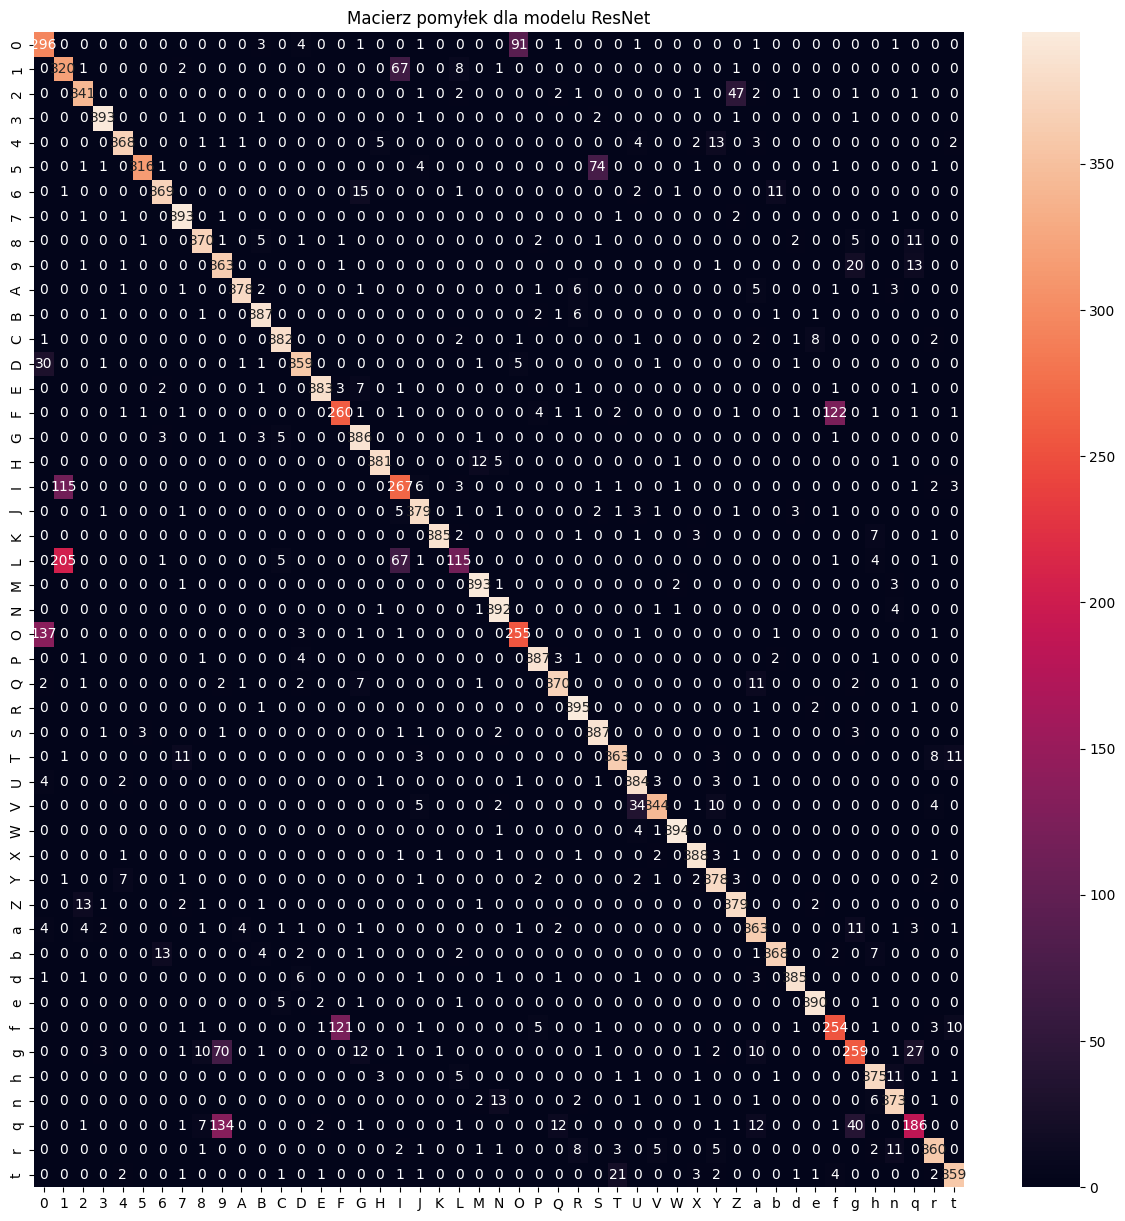

Model: SimpleCNN
Dokładność: 0.8476
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.62      0.32      0.43       400
           2       0.87      0.90      0.88       400
           3       0.97      0.96      0.96       400
           4       0.88      0.94      0.91       400
           5       0.95      0.80      0.87       400
           6       0.89      0.94      0.91       400
           7       0.92      0.97      0.94       400
           8       0.96      0.88      0.92       400
           9       0.67      0.74      0.71       400
          10       0.96      0.93      0.94       400
          11       0.98      0.92      0.95       400
          12       0.92      0.94      0.93       400
          13       0.95      0.82      0.88       400
          14       0.98      0.96      0.97       400
          15       0.74      0.45      0.56       400
          16       0.93 

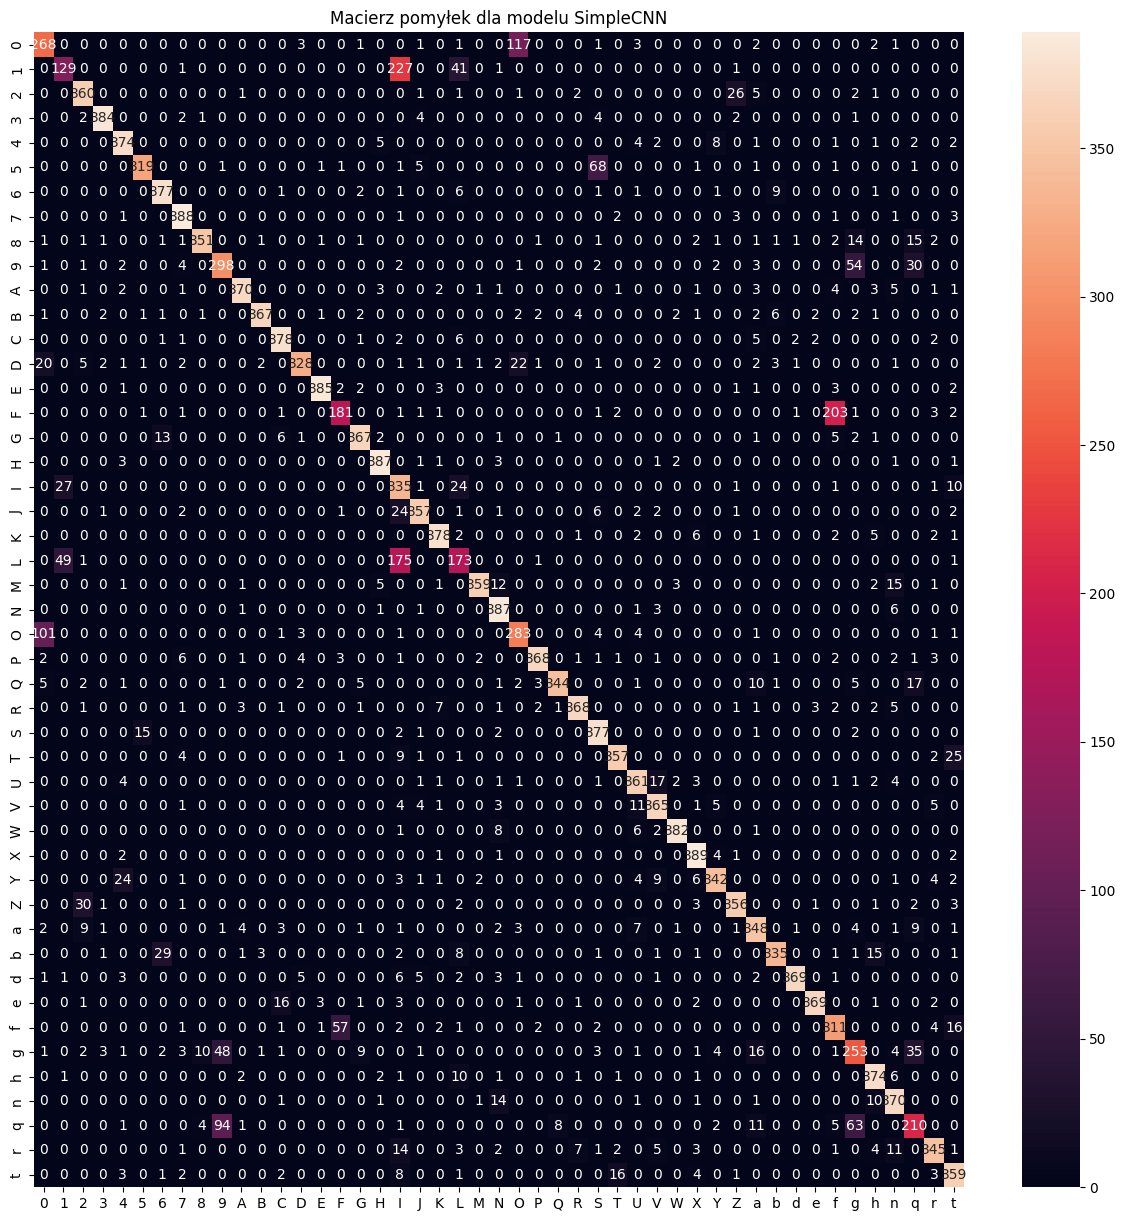

Model: SimpleCNNWide
Dokładność: 0.8627
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       400
           1       0.55      0.67      0.60       400
           2       0.86      0.91      0.88       400
           3       0.99      0.99      0.99       400
           4       0.95      0.88      0.91       400
           5       0.92      0.88      0.90       400
           6       0.82      0.98      0.89       400
           7       0.97      0.97      0.97       400
           8       0.93      0.95      0.94       400
           9       0.69      0.67      0.68       400
          10       0.93      0.97      0.95       400
          11       0.97      0.94      0.96       400
          12       0.96      0.93      0.94       400
          13       0.94      0.85      0.89       400
          14       0.97      0.94      0.96       400
          15       0.66      0.61      0.64       400
          16       0

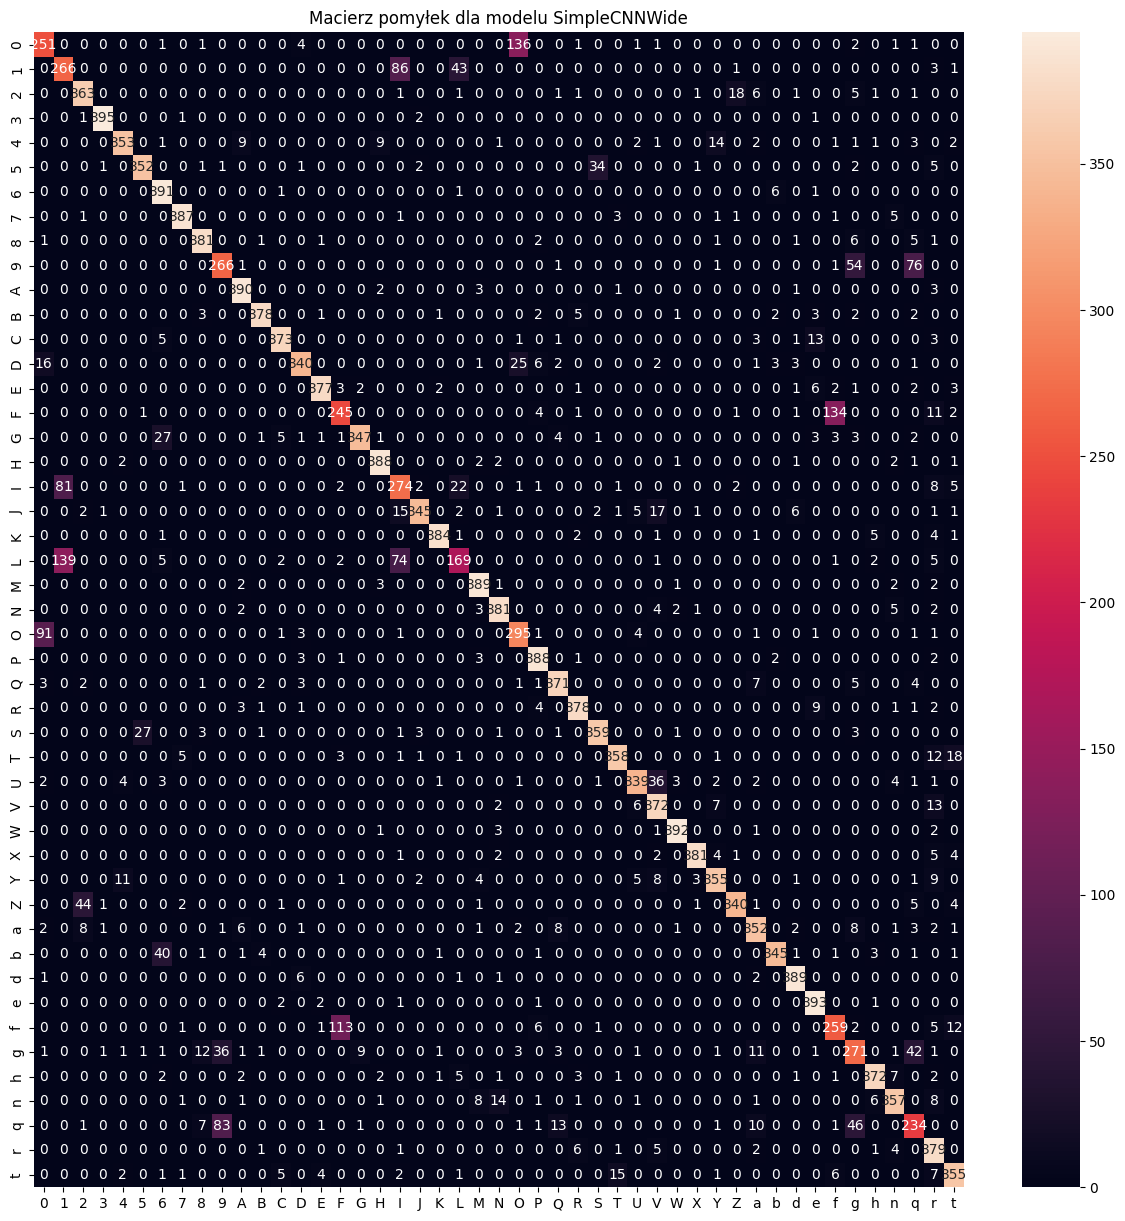

Model: SimpleCNNDeep
Dokładność: 0.8045
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.61      0.32      0.42       400
           1       0.00      0.00      0.00       400
           2       0.88      0.90      0.89       400
           3       0.98      0.95      0.97       400
           4       0.89      0.92      0.90       400
           5       1.00      0.38      0.55       400
           6       0.89      0.90      0.89       400
           7       0.98      0.90      0.94       400
           8       0.95      0.87      0.91       400
           9       0.65      0.82      0.73       400
          10       0.92      0.96      0.94       400
          11       0.98      0.86      0.92       400
          12       0.73      0.96      0.83       400
          13       0.95      0.74      0.83       400
          14       0.99      0.92      0.95       400
          15       0.69      0.41      0.52       400
          16       0

c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\matik\anaconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


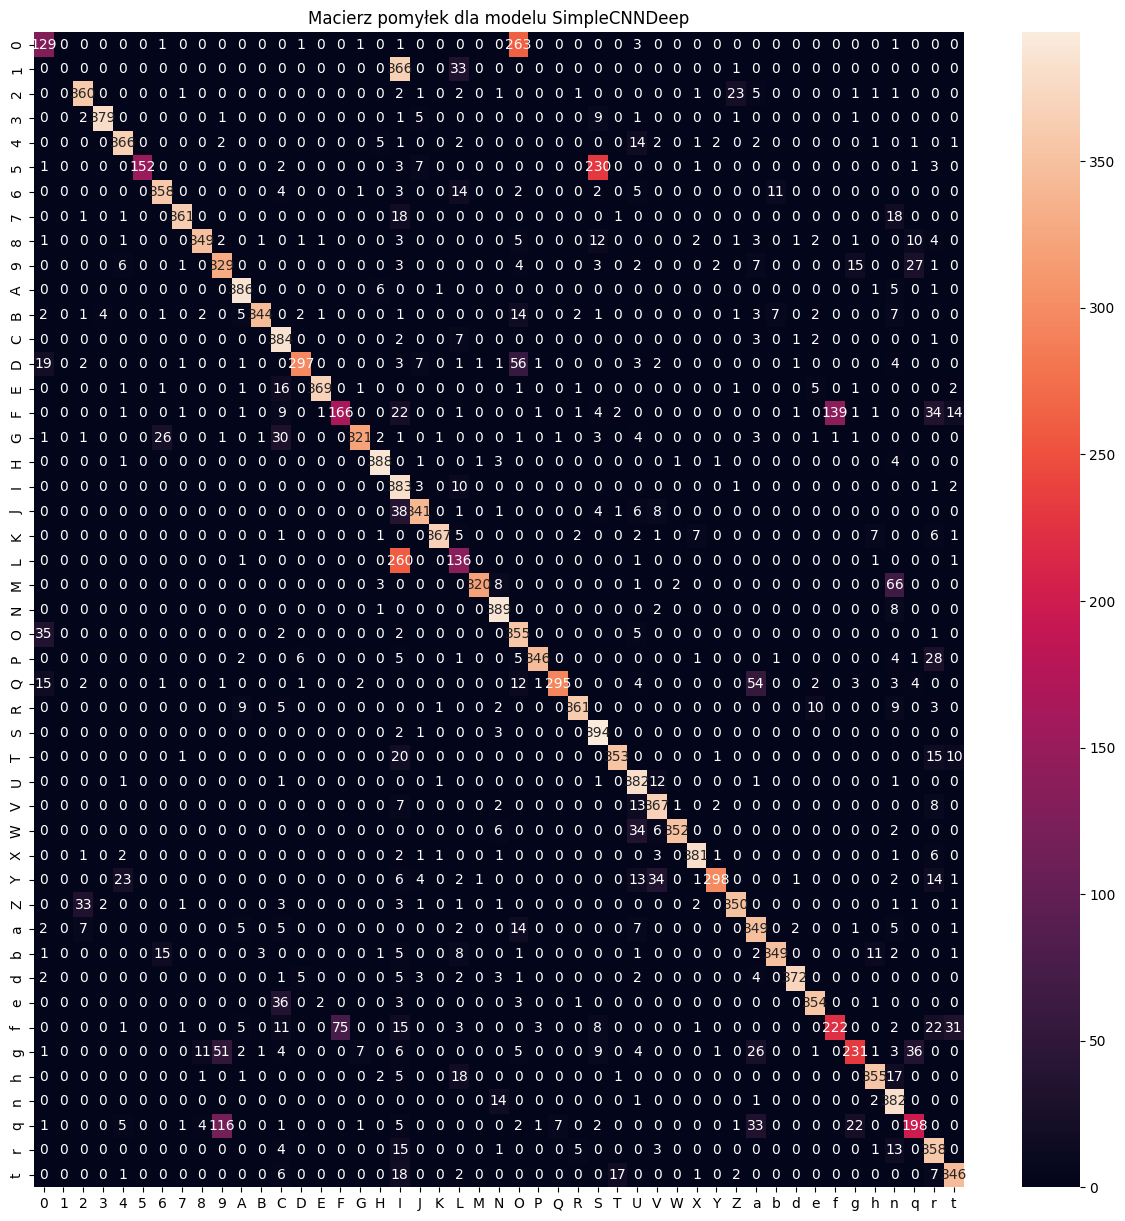

In [ ]:
for model in models:
    ocen_model(model, test_dataloader, class_names, y_test)

### Wnioski

Najlepiej z powyższych poradziła sobie zmodyfikowana architektura ResNet, osiągając najwyższą dokładność: powyżej 87%. Dalej w kolejności od najlepszego: Prosta sieć konwolucyjna - szeroka, podstawowa i głęboka. Na mapie ciepła widać, że wszystkie modele myliły się najczęściej dla tych samych klas. Mała dokładność dla tych klas ma sens, ponieważ faktycznie są to zbliżone kształty, na przykład: (q i 9), (l i 1), (0 i O)... Niektóre z tych przykładów są trudne do odróżnienia nawet dla człowieka.

#### Poniżej wyświetlę predykcje modeli dla najgorzej rozpoznawanych przykładów.

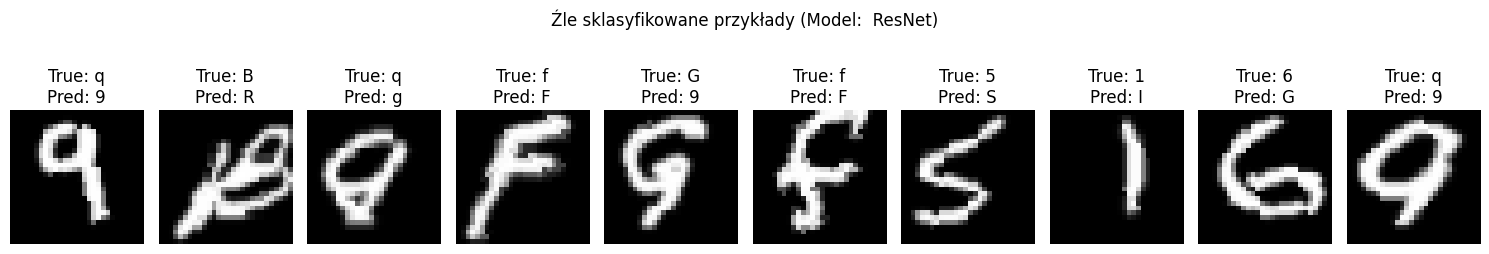

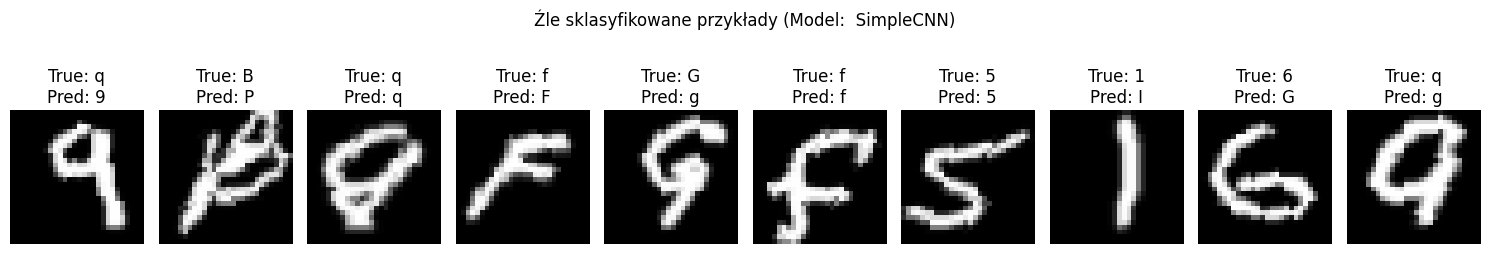

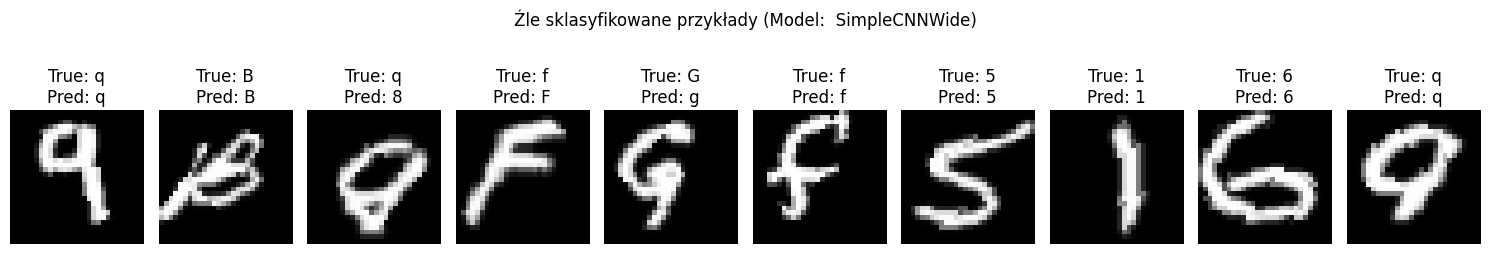

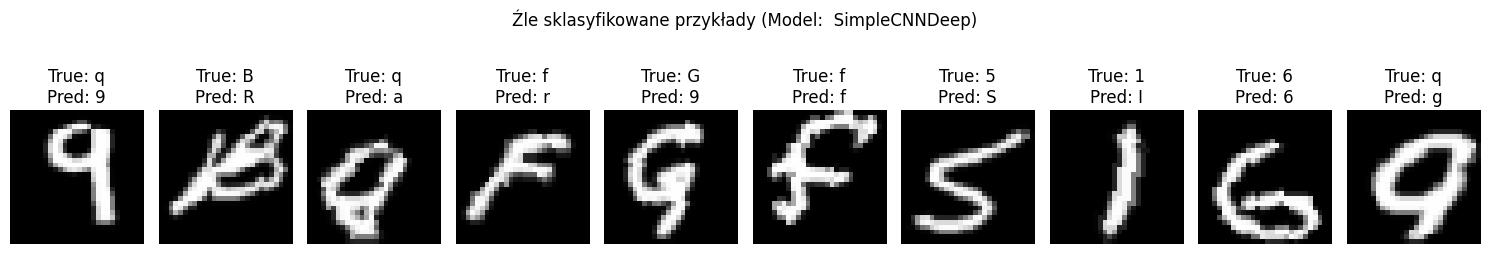

In [ ]:
misclassified_indices = None  # Do przechowywania indeksów źle sklasyfikowanych przykładów

for model_idx, model in enumerate(models):
    model.eval()

    # Weź batch danych z dataloadera
    inputs, labels = next(iter(test_dataloader))
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Wybierz błędne przykłady tylko dla pierwszego modelu
    if model_idx == 0:
        misclassified_indices = (preds != labels).nonzero(as_tuple=True)[0][:10] # 10 przykładów

    # Użyj tych samych indeksów dla pozostałych modeli
    misclassified_inputs = inputs[misclassified_indices]
    misclassified_labels = labels[misclassified_indices]
    misclassified_preds = preds[misclassified_indices]

    # Wizualizuj błędnie sklasyfikowane obrazy
    num_images = len(misclassified_inputs)
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, ax in enumerate(axes.flat[:num_images]):
            img = misclassified_inputs[i].cpu().numpy().squeeze()
            true_label = class_names[misclassified_labels[i].item()]
            pred_label = class_names[misclassified_preds[i].item()]

            ax.imshow(img, cmap='gray')
            ax.set_title(f'True: {true_label}\nPred: {pred_label}')
            ax.axis('off')

        plt.suptitle(f"Źle sklasyfikowane przykłady (Model:  {model.__class__.__name__})", y=0.8)
        plt.tight_layout()
        plt.show()

#### Wnioski

Na podstawie powyższych przykładów ze zbioru testowego można zauważyć, że są one faktycznie trudne do rozpoznania, nawet przez człowieka. Przykłady albo są bardzo podobne do siebie, albo niestarannie narysowane, co znacznie utrudnia zadanie klasyfikacji. Podsumowując, jesteśmy zadowoleni z wyników projektu. Modele w satysfakcjonującym stopniu rozpoznają znaki. Mimo, że wartość dokładności nie jest idealna, to jednak w obliczu wielu trudnych do sklasyfikowania przykładów, wynik jest zdecydowanie zadowalający.